In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from mpl_toolkits.axes_grid1 import ImageGrid

### Validate Data Path

In [2]:
cwd = os.getcwd()

## Place the data in Food-11 directory
data_in_dir = os.path.join(cwd, "Food-11")
assert(os.path.isdir(data_in_dir))

subdirs = {
    'train' : 'training',
    'valid' : 'validation',
    'eval'  : 'evaluation'}
dirs = os.listdir(data_in_dir)

## Validate we have these 3 subdirectories
#assert(len(dirs) == len(subdirs) and sorted(dirs) == sorted(subdirs.values()))

## Create output directory in current path to store images
image_dir = os.path.join(cwd, "food-classification-eda-images")
if not os.path.exists(image_dir): os.makedirs(image_dir)
    
## Create output directory to store the dataframes in pickle format
pickle_dir = os.path.join(cwd, "food-classification-pickle_data")
if not os.path.exists(pickle_dir): os.makedirs(pickle_dir)


### Read the images from directory

In [3]:
## training, validation and evluation data directories
training_data_dir = os.path.join(data_in_dir, subdirs['train'])
validation_data_dir = os.path.join(data_in_dir, subdirs['valid'])
evaluation_data_dir = os.path.join(data_in_dir, subdirs['eval'])

## training, validation and evluation data images
training_images = glob.glob(os.path.join(training_data_dir, "*"))
validation_images = glob.glob(os.path.join(validation_data_dir, "*"))
evaluation_images = glob.glob(os.path.join(evaluation_data_dir, "*"))

all_images = [training_images, validation_images, evaluation_images]
all_directories = [training_data_dir, validation_data_dir, evaluation_data_dir]

In [4]:
# Create dictionary of target classes
label_dict = {
 0: 'Bread',
 1: 'Dairy product',
 2: 'Dessert',
 3: 'Egg',
 4: 'Fried food',
 5: 'Meat',
 6: 'Noodles/Pasta',
 7: 'Rice',
 8: 'Seafood',
 9: 'Soup',
 10: 'Vegetable/Fruit',
}

## Prepare Training Dataframe

In [5]:
training = pd.DataFrame(training_images)
training.columns = ['Path']
training['Label'] = training.Path.apply(lambda x: os.path.basename(x).split('_')[0])
training.describe()

,Path,Label
count,9866,9866
unique,9866,11
top,C:\Users\WOLVCI10\Desktop\TensorFlow\AI-Food-C...,2
freq,1,1500


In [142]:
# function to return a set of N augmented images for each input image
#     input_images[ numImages x 128 x 128 x 3 ]
# returns output_images, output_labels which is input expanded by N

def augmentN(input_images, input_labels, numImages, numAugment):

    imageList = []
    labelList = []
    
    for jj in range(numImages):
        # put the original image into the list
        imageList.append(input_images[jj])
        labelList.append(input_labels[jj])
        
        for ii in range(numAugment):
            # rotate by random amount
            randomRadian = (np.pi/180) * tf.random_uniform([1], minval=0, maxval=10)
            aImage = tf.contrib.image.rotate(input_images[jj], randomRadian, interpolation='BILINEAR')
            aImage = tf.image.random_brightness(aImage, max_delta=0.3)
            aImage = tf.image.random_contrast(aImage, lower=0.75, upper=0.77)
            aImage = tf.image.random_flip_left_right(aImage)
            aImage = tf.image.random_flip_up_down(aImage)
            imageList.append(aImage) # add the augmented image to the list
            labelList.append(input_labels[jj]) # augmented image get same label as original image
            
    return(tf.stack(imageList), tf.stack(labelList))
    

In [143]:
'''
Helper function to visualize augmented images in single line. 
'''
def plot_aug_data(images, labels, numAug):
    fig = plt.figure(1, figsize=(16, 4))
    plt.title('Augmented images ')
    plt.axis('off')
    grid = ImageGrid(fig, 111, nrows_ncols=(1, numAug+1), axes_pad=0.05)  
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    img_idx=0
    for ii in range(numAug+1):
        ax = grid[img_idx]
        ax.text(0.5*(left+right), 0.5*(bottom+top), 
                label_dict[int(labels[ii])],ha='center',va='center',
                fontsize=20, color='red',transform=ax.transAxes)
        ax.grid(False)
        img = images[ii]
        ax.imshow(img)
        img_idx+=1

    plt.show()
    fig.savefig(os.path.join(image_dir, 'Test_Augmentation_Image.jpg'), bbox_inches='tight', pad_inches=0)

(50, 128, 128, 3)
(50,)
First dimension of output =  50 , which should match (numAug+1)*sampleSize =  50
For each image, the function outputs numAug images plus the original image


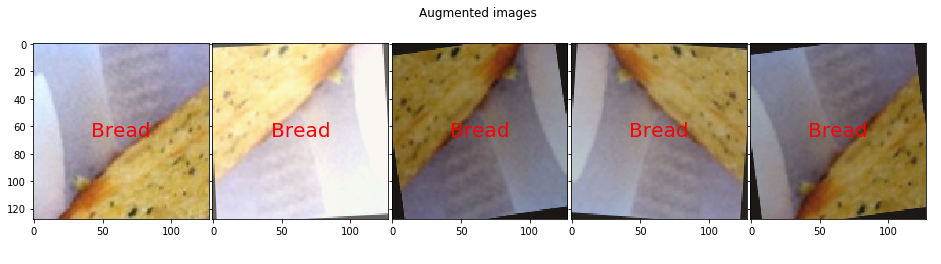

In [144]:
# Prepare a sample of images and labels for dictionary to feed to the augmentation
import tensorflow as tf
sampleSize = 10
imageDim = 128
numChan = 3
numAug = 4

imageA = np.zeros((sampleSize, imageDim, imageDim, numChan), dtype='uint8')
labelA = np.zeros(sampleSize)

for ix in range(sampleSize):
    img_path = training.Path[ix]
    img = io.imread(img_path)
    cat = training.Label[ix] # get the radiograph category
    
    # clip image to 128 x 128 x 3
    clipped = img[0:imageDim, 0:imageDim, 0:numChan]
    imageA[ix, 0:imageDim, 0:imageDim, 0:numChan] = clipped # clipped image
    labelA[ix] = cat                                        # corresponding label 
    
inI = tf.placeholder(tf.uint8, [None, imageDim, imageDim, numChan])    
inL = tf.placeholder(tf.uint8, [None])
    
[augImageTfA, augLabelTfA] = augmentN(inI, inL, sampleSize, numAug)
tf.set_random_seed(seed=0)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    [augImage, augLabel] = sess.run([augImageTfA, augLabelTfA], feed_dict={inI:imageA, inL:labelA})
    print(np.shape(augImage))
    print(np.shape(augLabel))
    print('First dimension of output = ', np.shape(augLabel)[0], ', which should match (numAug+1)*sampleSize = ', (numAug+1)*sampleSize)
    print('For each image, the function outputs numAug images plus the original image')
    plot_aug_data(augImage, augLabel, numAug)
    
    
